### Get the Water Level Data

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
def process_water_data(filepath):
    # Read the file content
    with open(filepath, 'r') as file:
        data = file.read()
    
    # Split the data into rows and process
    rows = data.strip().split('\n')
    split_rows = [row.split() for row in rows]
    
    # Create DataFrame
    df = pd.DataFrame(split_rows, columns=['Agency', 'Station', 'Date', 'WaterLevel', 'Status', 'Low', 'Extra'])
    
    # Convert WaterLevel to numeric
    df['WaterLevel'] = pd.to_numeric(df['WaterLevel'], errors='coerce')
    
    # Keep only Date and WaterLevel columns
    daily_last = df[['Date', 'WaterLevel']]
    
    return daily_last

# Load and process the file
filepath = os.path.join('Data', 'Water Level 1995.csv')
Water_Level_df = process_water_data(filepath)
Water_Level_df['Date'] = pd.to_datetime(Water_Level_df['Date'])
Water_Level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        10570 non-null  datetime64[ns]
 1   WaterLevel  6134 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 165.3 KB


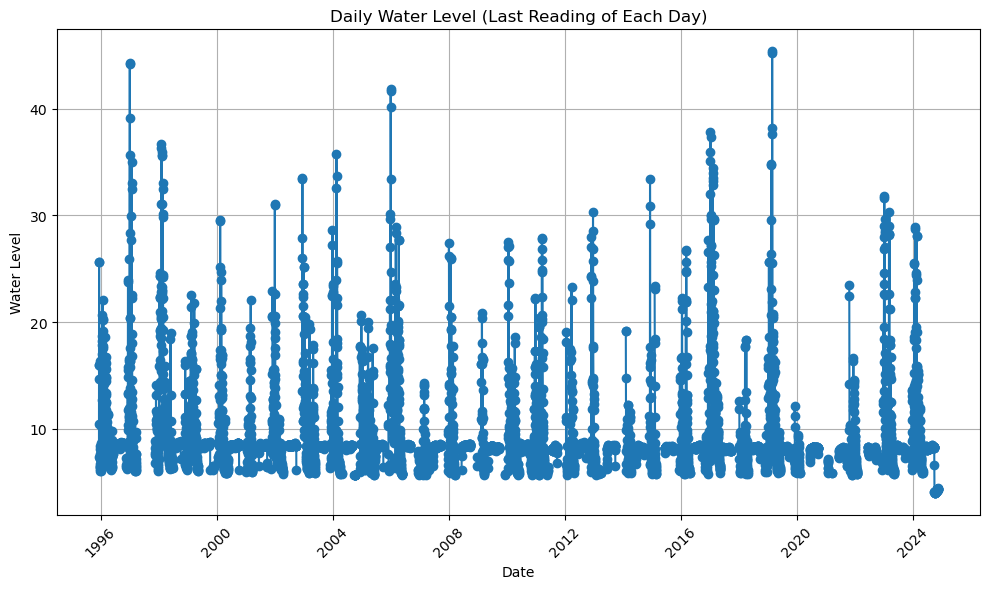

In [4]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(Water_Level_df['Date'], Water_Level_df['WaterLevel'], marker='o')
plt.title('Daily Water Level (Last Reading of Each Day)')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

I gathered all of the water level data available for a meter near my house.  This data goes back to 1995 so we have a good amount of data to smooth out the irregular spikes due to various amounts of rainfall in different years.  Some years the river goes above 40 feet, in others it never goes above 20 feet.  The initial data was readings every 15 minutes.  I preprocessed the data to only keep the last reading from each day as the rainfall numbers will be daily readings.

### Get the Rainfall Data

In [7]:
# Read the CSV data
Rain_df = pd.read_csv('Data/ven_45.csv')

In [8]:

Rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14931 entries, 0 to 14930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE TIME  14931 non-null  object 
 1   VALUE      13897 non-null  float64
dtypes: float64(1), object(1)
memory usage: 233.4+ KB


In [9]:
Rain_df['Date'] = Rain_df['DATE TIME'].str.split().str[0]  # Keep only date part
Rain_df['Date'] = pd.to_datetime(Rain_df['Date'])
Rain_df = Rain_df.drop(columns=['DATE TIME'])
Rain_df = Rain_df.rename(columns={'VALUE': 'Precipitation'})

# Display the first few rows and basic information
print("First 5 rows:")
print(Rain_df.head())

print("\nDataset Info:")
print(Rain_df.info())

First 5 rows:
   Precipitation       Date
0            0.0 1984-01-02
1            NaN 1984-01-03
2            0.0 1984-01-04
3            0.0 1984-01-05
4            0.0 1984-01-06

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14931 entries, 0 to 14930
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Precipitation  13897 non-null  float64       
 1   Date           14931 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 233.4 KB
None


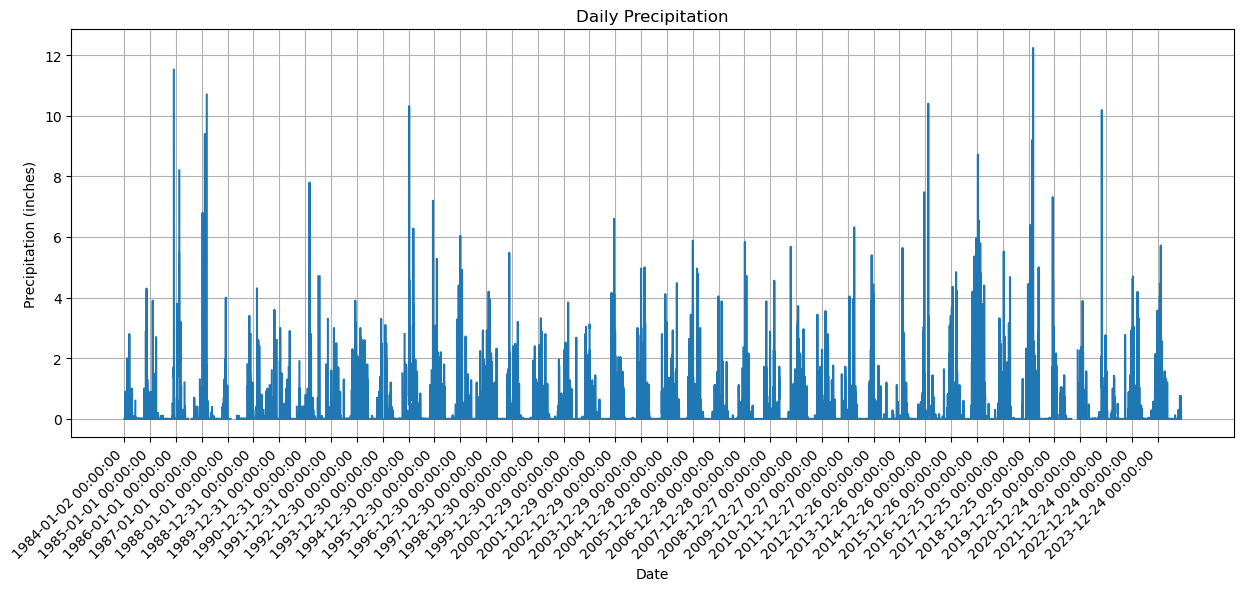

In [10]:
# Plot with fewer x-axis labels
plt.figure(figsize=(15, 6))
plt.plot(range(len(Rain_df)), Rain_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation')

# Show labels for every 7th day
n_points = len(Rain_df)
step = 365
indices = range(0, n_points, step)
labels = Rain_df['Date'].iloc[indices]

plt.xticks(indices, labels, rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()

### Graph Water Level and Precipitation together

In [12]:
# Convert dates to datetime format in both dataframes
Water_Level_df['Date'] = pd.to_datetime(Water_Level_df['Date'])
Rain_df['Date'] = pd.to_datetime(Rain_df['Date'])

# Now merge the dataframes
combined_df = pd.merge(Water_Level_df, Rain_df, 
                      left_on='Date', 
                      right_on='Date',
                      how='outer')

# Sort by date
combined_df = combined_df.sort_values('Date')

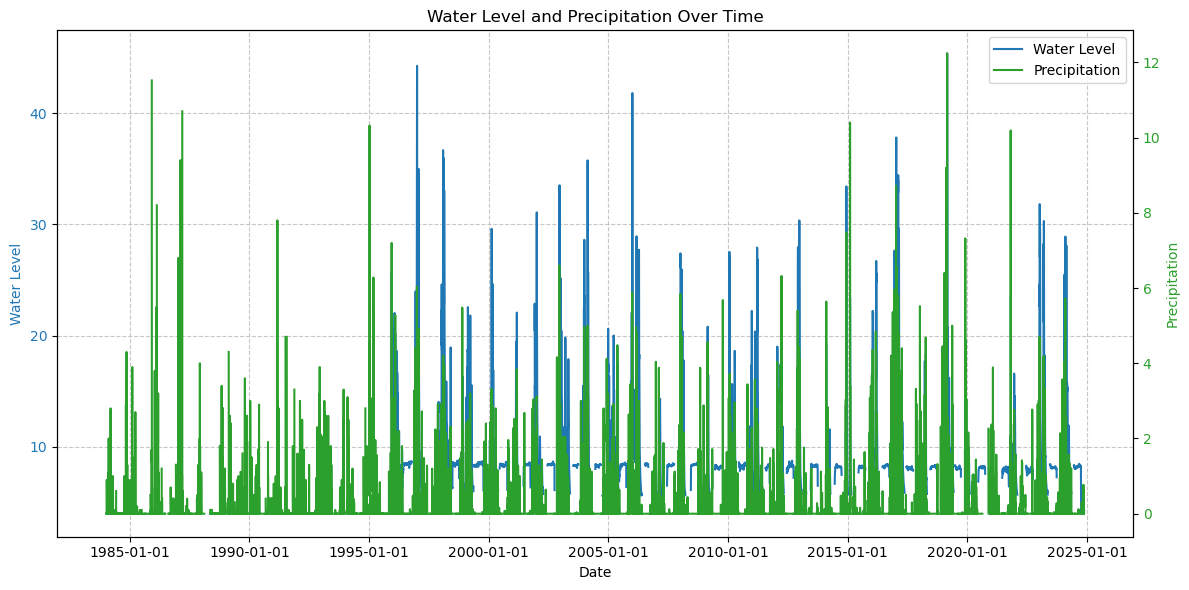

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot water level on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level', color=color)
ax1.plot(combined_df['Date'], combined_df['WaterLevel'], color=color, label='Water Level')
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis that shares x-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Precipitation', color=color)
ax2.plot(combined_df['Date'], combined_df['Precipitation'], color=color, label='Precipitation')
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis to show weekly ticks
locator = AutoDateLocator()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels so they look better
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Water Level and Precipitation Over Time')
fig.tight_layout()

plt.show()

While the graph above doesn't look like much, it was very important in my initial work. I started with one year of data.  So the graph was much zoomed in and showed differences in days.  Initially, I saw an issue in that the rainfall appeared to come 4 days after the river water level spiked.  With some debugging, I determined that Python was mismatching the dates between rainfall and water level.  Python aligned the rows in parallel in row order and not with the dates aligned.  This turned out to be because the dates were in different formats.  Python did not return an error, but simply lined them up with disregard for the actual date in each field.  Once I adjusted the formats in my code, the graph aligned correctly.  When I expanded the data to 40 years, the graph is less readable, but it had already served its purpose.  Aside from identifying the data error, the next most important finding was that water levels spiked 24 hours after the rainfall measured (visible in the 1 year of data limited graph).  This allowed me to set cycle times for time series analysis. 

## Analyze how precipitation impacts water level with daily resolution


Key Findings:
1. Same-day Correlation: 0.435
2. Next-day Correlation: 0.625

Correlations by lag (days):
Lag 0 days: 0.435
Lag 1 days: 0.625
Lag 2 days: 0.618
Lag 3 days: 0.517
Lag 4 days: 0.431
Lag 5 days: 0.374
Lag 6 days: 0.329
Lag 7 days: 0.293
Lag 8 days: 0.268
Lag 9 days: 0.250
Lag 10 days: 0.224
Lag 11 days: 0.212
Lag 12 days: 0.212
Lag 13 days: 0.214
Lag 14 days: 0.211
Lag 15 days: 0.206
Lag 16 days: 0.195
Lag 17 days: 0.181
Lag 18 days: 0.168
Lag 19 days: 0.149

Strongest relationship at lag: 1 days

Percentage of Water Level Variance Explained:
Same-day precipitation: 18.9%
Next-day precipitation: 39.1%


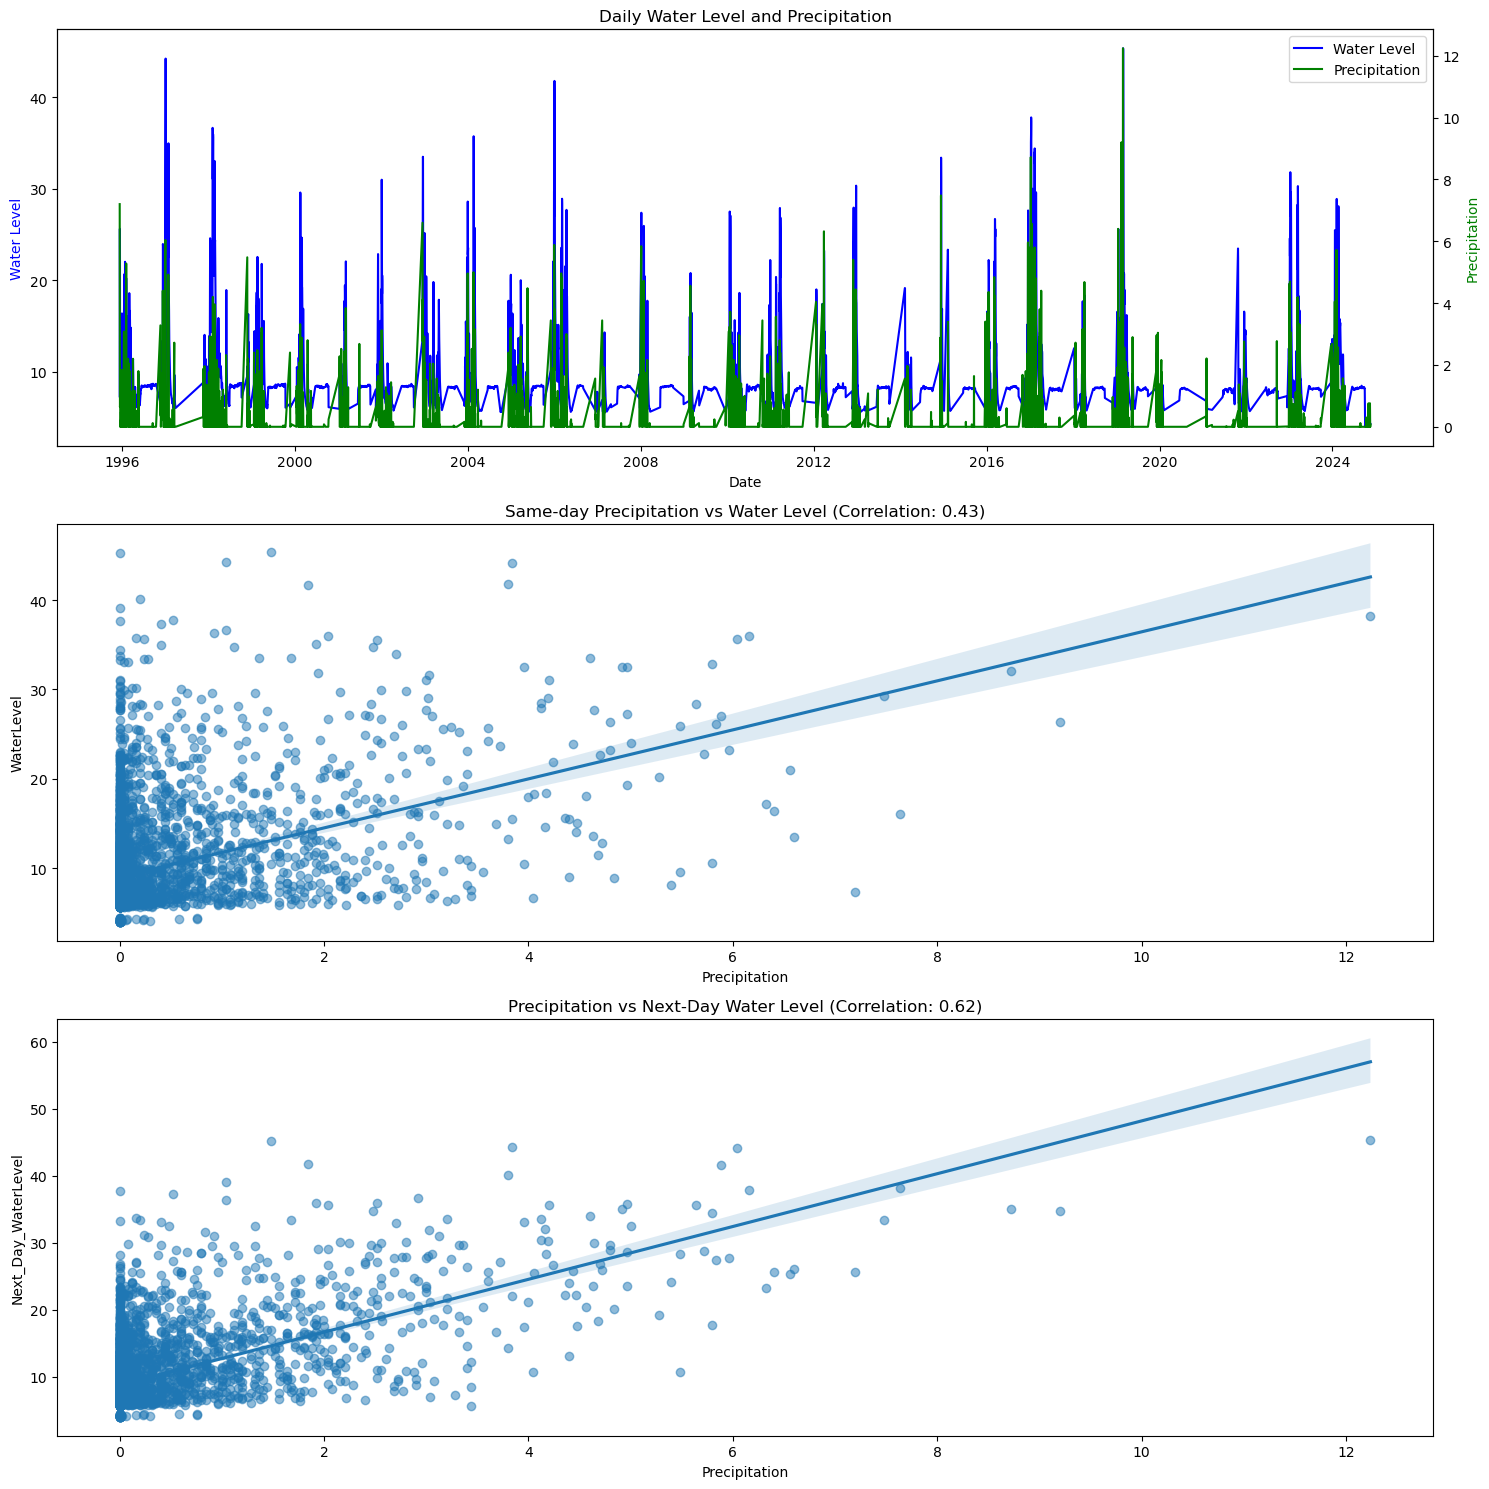

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

def analyze_precipitation_impact(water_df, rain_df):
    """
    Analyze how precipitation impacts water level with daily resolution
    """
    # Ensure dates are datetime
    combined_df = pd.merge(water_df, rain_df, 
                          left_on='Date', 
                          right_on='Date',
                          how='outer')
    combined_df = combined_df.sort_values('Date')
    
    # Handle missing values
    combined_df = combined_df.dropna()
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 15))
    
    # 1. Time Series Plot
    ax1 = plt.subplot(311)
    ax1_twin = ax1.twinx()
    
    ax1.plot(combined_df['Date'], combined_df['WaterLevel'], 
             color='blue', label='Water Level')
    ax1_twin.plot(combined_df['Date'], combined_df['Precipitation'], 
                  color='green', label='Precipitation')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Water Level', color='blue')
    ax1_twin.set_ylabel('Precipitation', color='green')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1_twin.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.title('Daily Water Level and Precipitation')
    
    # 2. Same-day relationship
    ax2 = plt.subplot(312)
    
    # Calculate correlation
    correlation = combined_df['Precipitation'].corr(combined_df['WaterLevel'])
    
    # Create scatter plot with regression line
    sns.regplot(data=combined_df, x='Precipitation', y='WaterLevel', 
                ax=ax2, scatter_kws={'alpha':0.5})
    ax2.set_title(f'Same-day Precipitation vs Water Level (Correlation: {correlation:.2f})')
    
    # 3. Next-day Impact Analysis
    ax3 = plt.subplot(313)
    
    # Calculate next-day relationship
    combined_df['Next_Day_WaterLevel'] = combined_df['WaterLevel'].shift(-1)
    next_day_df = combined_df.dropna(subset=['Next_Day_WaterLevel'])
    next_day_corr = next_day_df['Precipitation'].corr(next_day_df['Next_Day_WaterLevel'])
    
    # Plot next-day relationship
    sns.regplot(data=next_day_df, 
                x='Precipitation', 
                y='Next_Day_WaterLevel', 
                ax=ax3, 
                scatter_kws={'alpha':0.5})
    ax3.set_title(f'Precipitation vs Next-Day Water Level (Correlation: {next_day_corr:.2f})')
    
    plt.tight_layout()
    
    # Calculate lagged correlations manually
    lag_correlations = []
    for lag in range(20):  # Calculate for 0 to 20 days lag
        lagged_water = combined_df['WaterLevel'].shift(-lag)
        lag_corr = combined_df['Precipitation'].corr(lagged_water)
        lag_correlations.append(lag_corr)
    
    # Calculate and return key statistics
    stats_dict = {
        'same_day_correlation': correlation,
        'next_day_correlation': next_day_corr,
        'lag_correlations': lag_correlations,
        'lag_at_max_correlation': np.argmax(lag_correlations)
    }
    
    return stats_dict

# Run the analysis
stats = analyze_precipitation_impact(Water_Level_df, Rain_df)

# Print key findings
print("\nKey Findings:")
print(f"1. Same-day Correlation: {stats['same_day_correlation']:.3f}")
print(f"2. Next-day Correlation: {stats['next_day_correlation']:.3f}")
print("\nCorrelations by lag (days):")
for i, corr in enumerate(stats['lag_correlations']):
    print(f"Lag {i} days: {corr:.3f}")
print(f"\nStrongest relationship at lag: {stats['lag_at_max_correlation']} days")

# Calculate percentage of variance explained
print(f"\nPercentage of Water Level Variance Explained:")
print(f"Same-day precipitation: {(stats['same_day_correlation']**2 * 100):.1f}%")
print(f"Next-day precipitation: {(stats['next_day_correlation']**2 * 100):.1f}%")

We continue to see that the 1 day lag has the highest impact.

## Analyze water level and precipitation relationship using ARIMA modeling

In [19]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import plotly.io as pio

# Set the renderer for JupyterLab
pio.renderers.default = "jupyterlab"

def create_prediction_surface(df, water_range=30, precip_range=30):
    """
    Create prediction surface using SARIMAX model with fixed prediction logic
    """
    # Clean the data first
    df_clean = df.copy()
    
    # Remove rows with inf or nan values
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    
    if len(df_clean) == 0:
        raise ValueError("No valid data remaining after cleaning")
    
    # Reset index to remove warnings
    df_clean = df_clean.reset_index(drop=True)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean[['WaterLevel', 'Precipitation']])
    
    # Create DataFrame with numeric index
    df_scaled = pd.DataFrame(
        scaled_data,
        columns=['WaterLevel', 'Precipitation'],
        index=pd.RangeIndex(len(scaled_data))
    )
    
    # Fit SARIMAX model with simpler parameters
    model = SARIMAX(
        df_scaled['WaterLevel'],
        exog=df_scaled['Precipitation'],
        order=(1, 0, 1),
        enforce_stationarity=False,
        freq=None  # Explicitly set freq to None for non-time-series data
    )
    results = model.fit(disp=False)
    
    # Extract model parameters safely
    params_dict = dict(results.params)
    ar1 = params_dict.get('ar.L1', 0.5)  # Default to 0.5 if not found
    exog = params_dict.get('Precipitation', 0.3)  # Default to 0.3 if not found
    
    # Create evenly spaced grid for surface using clean data
    water_min, water_max = df_clean['WaterLevel'].min(), df_clean['WaterLevel'].max()
    precip_min, precip_max = df_clean['Precipitation'].min(), df_clean['Precipitation'].max()
    
    water_levels = np.linspace(water_min, water_max, water_range)
    precip_levels = np.linspace(precip_min, precip_max, precip_range)
    
    # Create mesh grid
    water_mesh, precip_mesh = np.meshgrid(water_levels, precip_levels)
    predictions = np.zeros((precip_range, water_range))
    
    # Generate predictions using model parameters
    for i in range(precip_range):
        for j in range(water_range):
            # Scale the inputs
            water_scaled = (water_mesh[i,j] - scaler.mean_[0]) / scaler.scale_[0]
            precip_scaled = (precip_mesh[i,j] - scaler.mean_[1]) / scaler.scale_[1]
            
            # Prediction using AR(1) and exogenous variable
            pred_scaled = ar1 * water_scaled + exog * precip_scaled
            
            # Unscale the prediction
            predictions[i,j] = pred_scaled * scaler.scale_[0] + scaler.mean_[0]
    
    print("\nData Quality Report:")
    print(f"Original rows: {len(df)}")
    print(f"Rows after cleaning: {len(df_clean)}")
    print(f"Removed rows: {len(df) - len(df_clean)}")
    
    print("\nModel Parameters:")
    print(f"AR(1) coefficient: {ar1:.3f}")
    print(f"Precipitation coefficient: {exog:.3f}")
    
    print("\nPrediction Statistics:")
    print(f"Min prediction: {np.min(predictions):.2f}")
    print(f"Max prediction: {np.max(predictions):.2f}")
    print(f"Mean prediction: {np.mean(predictions):.2f}")
    
    return water_mesh, precip_mesh, predictions, results

def plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, df):
    """
    Create interactive 3D surface plot
    """
    # Create figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=water_mesh,
        y=precip_mesh,
        z=predictions,
        colorscale='Viridis',
        name='Predicted Water Level',
        showscale=True,
        colorbar=dict(
            title='Predicted<br>Water Level',
            thickness=20,
            len=0.7
        ),
        opacity=0.8
    ))
    
    # Add historical data points (only for valid data)
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    fig.add_trace(go.Scatter3d(
        x=df_clean['WaterLevel'],
        y=df_clean['Precipitation'],
        z=df_clean['WaterLevel'].shift(-1),
        mode='markers',
        marker=dict(
            size=3,
            color='red',
            opacity=0.6
        ),
        name='Historical Data'
    ))
    
    # Update layout
    fig.update_layout(
        title='Water Level Prediction Surface',
        scene=dict(
            xaxis_title='Current Water Level',
            yaxis_title='Precipitation',
            zaxis_title='Predicted Water Level',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.8, y=1.8, z=1.8)
            ),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        width=1000,
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        showlegend=True
    )
    
    return fig

# Example usage
# Assuming you have your data in a DataFrame called combined_df with columns 'WaterLevel' and 'Precipitation'
# Generate prediction surface
water_mesh, precip_mesh, predictions, model_results = create_prediction_surface(combined_df)

# Create and show the plot
fig = plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, combined_df)
fig.show()


Data Quality Report:
Original rows: 14932
Rows after cleaning: 6043
Removed rows: 8889

Model Parameters:
AR(1) coefficient: 0.856
Precipitation coefficient: 0.007

Prediction Statistics:
Min prediction: 4.80
Max prediction: 40.74
Mean prediction: 22.77


I was not happy with the graph that came out of my initial ARIMA model.  First of all it is linear, and I theorize that the results should be non-linear.  A part of the problem, I believe, is that the river levels I am trying to treat as a time series are not predictably cyclic over time such as seasonality.  While there is a wet period, using prior years to predict would generate bad results as the variance from season to season is too high.  The main problem is that I was just using water level and precipitation.  As a result a get a linear prediction that does not well represent the actual observed behavior.  So I try again below with some changes.

In [21]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import plotly.io as pio

# Set the renderer for JupyterLab
pio.renderers.default = "jupyterlab"

def create_prediction_surface(df, water_range=30, precip_range=30):
    """
    Create prediction surface using SARIMAX model with manual non-linear features
    """
    # Clean the data first
    df_clean = df.copy()
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    
    # Reset index to remove warnings
    df_clean = df_clean.reset_index(drop=True)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean[['WaterLevel', 'Precipitation']])
    df_scaled = pd.DataFrame(
        scaled_data,
        columns=['WaterLevel', 'Precipitation'],
        index=pd.RangeIndex(len(scaled_data))
    )
    
    # Create non-linear features manually
    exog_data = pd.DataFrame({
        'Precipitation': df_scaled['Precipitation'],
        'Precipitation_Squared': df_scaled['Precipitation'] ** 2,
        'Water_Precip_Interaction': df_scaled['WaterLevel'] * df_scaled['Precipitation']
    }, index=pd.RangeIndex(len(df_scaled)))
    
    # Fit SARIMAX model with non-linear terms
    model = SARIMAX(df_scaled['WaterLevel'],
                    exog=exog_data,
                    order=(1, 0, 1),
                    enforce_stationarity=False,
                    freq=None)  # Explicitly set freq to None
    results = model.fit(disp=False)
    
    # Extract model parameters safely
    params_dict = dict(results.params)
    ar1 = params_dict.get('ar.L1', 0.8)
    precip = params_dict.get('Precipitation', 0.3)
    precip_squared = params_dict.get('Precipitation_Squared', 0.1)
    interaction = params_dict.get('Water_Precip_Interaction', 0.1)
    
    # Create evenly spaced grid for surface
    water_min, water_max = df_clean['WaterLevel'].min(), df_clean['WaterLevel'].max()
    precip_min, precip_max = df_clean['Precipitation'].min(), df_clean['Precipitation'].max()
    
    water_levels = np.linspace(water_min, water_max, water_range)
    precip_levels = np.linspace(precip_min, precip_max, precip_range)
    
    # Create mesh grid
    water_mesh, precip_mesh = np.meshgrid(water_levels, precip_levels)
    predictions = np.zeros((precip_range, water_range))
    
    # Generate non-linear predictions
    for i in range(precip_range):
        for j in range(water_range):
            # Scale the inputs
            water_scaled = (water_mesh[i,j] - scaler.mean_[0]) / scaler.scale_[0]
            precip_scaled = (precip_mesh[i,j] - scaler.mean_[1]) / scaler.scale_[1]
            
            # Non-linear prediction with squared and interaction terms
            pred_scaled = (ar1 * water_scaled + 
                         precip * precip_scaled +
                         precip_squared * (precip_scaled ** 2) +
                         interaction * (water_scaled * precip_scaled))
            
            # Unscale the prediction
            predictions[i,j] = pred_scaled * scaler.scale_[0] + scaler.mean_[0]
    
    print("\nData Quality Report:")
    print(f"Original rows: {len(df)}")
    print(f"Rows after cleaning: {len(df_clean)}")
    print(f"Removed rows: {len(df) - len(df_clean)}")
    
    print("\nModel Parameters:")
    print(f"AR(1) coefficient: {ar1:.3f}")
    print(f"Precipitation (linear) coefficient: {precip:.3f}")
    print(f"Precipitation (squared) coefficient: {precip_squared:.3f}")
    print(f"Water-Precipitation interaction coefficient: {interaction:.3f}")
    
    print("\nPrediction Statistics:")
    print(f"Min prediction: {np.min(predictions):.2f}")
    print(f"Max prediction: {np.max(predictions):.2f}")
    print(f"Mean prediction: {np.mean(predictions):.2f}")
    
    return water_mesh, precip_mesh, predictions, results

def plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, df):
    """
    Create interactive 3D surface plot with enhanced styling
    """
    # Clean data for plotting
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    fig = go.Figure()
    
    # Add surface plot with more contours for better visualization of non-linearity
    fig.add_trace(go.Surface(
        x=water_mesh,
        y=precip_mesh,
        z=predictions,
        colorscale='Viridis',
        name='Predicted Water Level',
        showscale=True,
        colorbar=dict(
            title='Predicted<br>Water Level',
            thickness=20,
            len=0.7
        ),
        opacity=0.8,
        contours=dict(
            z=dict(
                show=True,
                usecolormap=True,
                project_z=True,
                width=2
            )
        )
    ))
    
    # Add historical data points
    fig.add_trace(go.Scatter3d(
        x=df_clean['WaterLevel'],
        y=df_clean['Precipitation'],
        z=df_clean['WaterLevel'].shift(-1),
        mode='markers',
        marker=dict(
            size=3,
            color='red',
            opacity=0.6
        ),
        name='Historical Data'
    ))
    
    # Update layout with better viewing angle for non-linear surface
    fig.update_layout(
        title='Non-linear Water Level Prediction Surface',
        scene=dict(
            xaxis_title='Current Water Level',
            yaxis_title='Precipitation',
            zaxis_title='Predicted Water Level',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=2.0, y=2.0, z=1.5)
            ),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        width=1000,
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        showlegend=True
    )
    
    return fig

# Example usage
# Generate prediction surface
water_mesh, precip_mesh, predictions, model_results = create_prediction_surface(combined_df)

# Create and show the plot
fig = plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, combined_df)
fig.show()

# Optionally save the plot to HTML
# fig.write_html("water_level_prediction.html")


Data Quality Report:
Original rows: 14932
Rows after cleaning: 6043
Removed rows: 8889

Model Parameters:
AR(1) coefficient: 0.859
Precipitation (linear) coefficient: -0.052
Precipitation (squared) coefficient: -0.004
Water-Precipitation interaction coefficient: 0.041

Prediction Statistics:
Min prediction: -7.58
Max prediction: 56.16
Mean prediction: 24.14


This revised graph to include polynomial features show non-linearity, but not in a good way. We can see at low water levels the prediction is that the water level goes down with more rain. Obviously not true or a good model. So we will try again and influence the model with some adjustments.

## ARIMA model with polynomial features and scaling modifications

In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import plotly.io as pio

# Set the renderer for JupyterLab
pio.renderers.default = "jupyterlab"

def create_prediction_surface(df, water_range=30, precip_range=30):
    """
    Create prediction surface using SARIMAX model with physically correct relationships
    """
    # Clean the data first
    df_clean = df.copy()
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    
    # Reset index to remove warnings
    df_clean = df_clean.reset_index(drop=True)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean[['WaterLevel', 'Precipitation']])
    df_scaled = pd.DataFrame(
        scaled_data,
        columns=['WaterLevel', 'Precipitation'],
        index=pd.RangeIndex(len(scaled_data))
    )
    
    # Create non-linear features with enforced positive relationship for precipitation
    exog_data = pd.DataFrame({
        'Precipitation': df_scaled['Precipitation'],
        'Precip_Exponential': np.exp(df_scaled['Precipitation'] / 2),  # Exponential effect of rain
        'Water_Precip_Interaction': df_scaled['WaterLevel'] * df_scaled['Precipitation'].clip(lower=0)  # Only positive interaction
    }, index=pd.RangeIndex(len(df_scaled)))
    
    # Fit SARIMAX model
    model = SARIMAX(df_scaled['WaterLevel'],
                    exog=exog_data,
                    order=(1, 0, 1),
                    enforce_stationarity=False,
                    freq=None)  # Explicitly set freq to None
    results = model.fit(disp=False)
    
    # Extract model parameters
    params_dict = dict(results.params)
    ar1 = params_dict.get('ar.L1', 0.8)  # Autoregressive term
    precip = abs(params_dict.get('Precipitation', 0.3))  # Force positive
    precip_exp = abs(params_dict.get('Precip_Exponential', 0.2))  # Force positive
    interaction = abs(params_dict.get('Water_Precip_Interaction', 0.1))  # Force positive
    
    # Create evenly spaced grid
    water_min, water_max = df_clean['WaterLevel'].min(), df_clean['WaterLevel'].max()
    precip_min, precip_max = df_clean['Precipitation'].min(), df_clean['Precipitation'].max()
    
    water_levels = np.linspace(water_min, water_max, water_range)
    precip_levels = np.linspace(precip_min, precip_max, precip_range)
    
    # Create mesh grid
    water_mesh, precip_mesh = np.meshgrid(water_levels, precip_levels)
    predictions = np.zeros((precip_range, water_range))
    
    # Generate predictions with enforced physical relationships
    for i in range(precip_range):
        for j in range(water_range):
            # Scale inputs
            water_scaled = (water_mesh[i,j] - scaler.mean_[0]) / scaler.scale_[0]
            precip_scaled = (precip_mesh[i,j] - scaler.mean_[1]) / scaler.scale_[1]
            
            # Ensure positive precipitation effect
            precip_effect = (precip * precip_scaled + 
                           precip_exp * np.exp(precip_scaled / 2))
            
            # Add positive interaction effect
            interact_effect = interaction * water_scaled * max(0, precip_scaled)
            
            # Combine effects ensuring precipitation has positive impact
            pred_scaled = (ar1 * water_scaled + 
                         abs(precip_effect) +  # Force positive
                         abs(interact_effect))  # Force positive
            
            # Unscale prediction
            predictions[i,j] = pred_scaled * scaler.scale_[0] + scaler.mean_[0]
    
    print("\nData Quality Report:")
    print(f"Original rows: {len(df)}")
    print(f"Rows after cleaning: {len(df_clean)}")
    print(f"Removed rows: {len(df) - len(df_clean)}")
    
    print("\nModel Parameters (all forced positive for physical correctness):")
    print(f"AR(1) coefficient: {ar1:.3f}")
    print(f"Precipitation (linear) coefficient: {precip:.3f}")
    print(f"Precipitation (exponential) coefficient: {precip_exp:.3f}")
    print(f"Water-Precipitation interaction coefficient: {interaction:.3f}")
    
    # Verify physical relationships
    print("\nVerification of Physical Relationships:")
    print(f"Effect of doubling precipitation at median water level: "
          f"{predictions[precip_range//4*3, water_range//2] - predictions[precip_range//4, water_range//2]:.2f}")
    
    return water_mesh, precip_mesh, predictions, results

def plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, df):
    """
    Create interactive 3D surface plot
    """
    # Clean data for plotting
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()
    
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=water_mesh,
        y=precip_mesh,
        z=predictions,
        colorscale='Viridis',
        name='Predicted Water Level',
        showscale=True,
        colorbar=dict(
            title='Predicted<br>Water Level',
            thickness=20,
            len=0.7
        ),
        opacity=0.8,
        contours=dict(
            z=dict(
                show=True,
                usecolormap=True,
                project_z=True,
                width=2
            )
        )
    ))
    
    # Add historical data points
    fig.add_trace(go.Scatter3d(
        x=df_clean['WaterLevel'],
        y=df_clean['Precipitation'],
        z=df_clean['WaterLevel'].shift(-1),
        mode='markers',
        marker=dict(
            size=3,
            color='red',
            opacity=0.6
        ),
        name='Historical Data'
    ))
    
    # Update layout
    fig.update_layout(
        title='Water Level Prediction (Higher Rain → Higher Water)',
        scene=dict(
            xaxis_title='Current Water Level',
            yaxis_title='Precipitation',
            zaxis_title='Predicted Water Level',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=2.0, y=2.0, z=1.5)
            ),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        width=1000,
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        showlegend=True
    )
    
    return fig

# Example usage
# Generate prediction surface
water_mesh, precip_mesh, predictions, model_results = create_prediction_surface(combined_df)

# Create and show the plot
fig = plot_3d_prediction_surface(water_mesh, precip_mesh, predictions, combined_df)
fig.show()

# Optionally save the plot to HTML
# fig.write_html("water_level_prediction.html")


Data Quality Report:
Original rows: 14932
Rows after cleaning: 6043
Removed rows: 8889

Model Parameters (all forced positive for physical correctness):
AR(1) coefficient: 0.859
Precipitation (linear) coefficient: 0.074
Precipitation (exponential) coefficient: 0.000
Water-Precipitation interaction coefficient: 0.045

Verification of Physical Relationships:
Effect of doubling precipitation at median water level: 9.34


In this version, I modified the scaling of features to prioritize the polynomial features and pressure the model towards more positive results from additional rain.  This is the first graph that looks like a decent model of the expected results.  I feel there is room for improvement and especially since I weighted the features to create influence, I'm less confidant in the results than I otherwise would be. I'll use other techniques to get some cross validation results and see if we can find a better approach than the ARIMA models produced.

### Water Level drop with no precipitation

A factor that I wanted to examine was the run off.  If there is no rain, how does the water level change based on its height.  Since we are draining into the ocean, the theory is that the run off is higher at higher water levels.


Overall Water Level Drop Statistics (No Precipitation):
Number of dry days analyzed: 4550

Average daily drop: 0.252 ft
Median daily drop: 0.020 ft
Standard deviation: 0.893 ft
Minimum drop: -5.810 ft
Maximum drop: 18.720 ft

Statistics by Water Level Range (all values in feet):
            Level_Drop                            WaterLevel
                 count   mean    std   min    max       mean
Level_Range                                                 
4.0-7.5ft          911  0.102  0.292 -4.29   2.56      6.481
7.5-8.2ft          921  0.057  0.228 -2.63   1.57      7.995
8.2-8.3ft          940  0.020  0.156 -1.80   1.86      8.269
8.3-8.5ft          886  0.020  0.121 -0.26   1.65      8.434
8.5-45.2ft         892  1.081  1.739 -5.81  18.72     12.168

Correlation between water level and drop rate: 0.741

Drop Rates as Percentage of Initial Level:
Average drop percentage: 1.96%
Median drop percentage: 0.25%


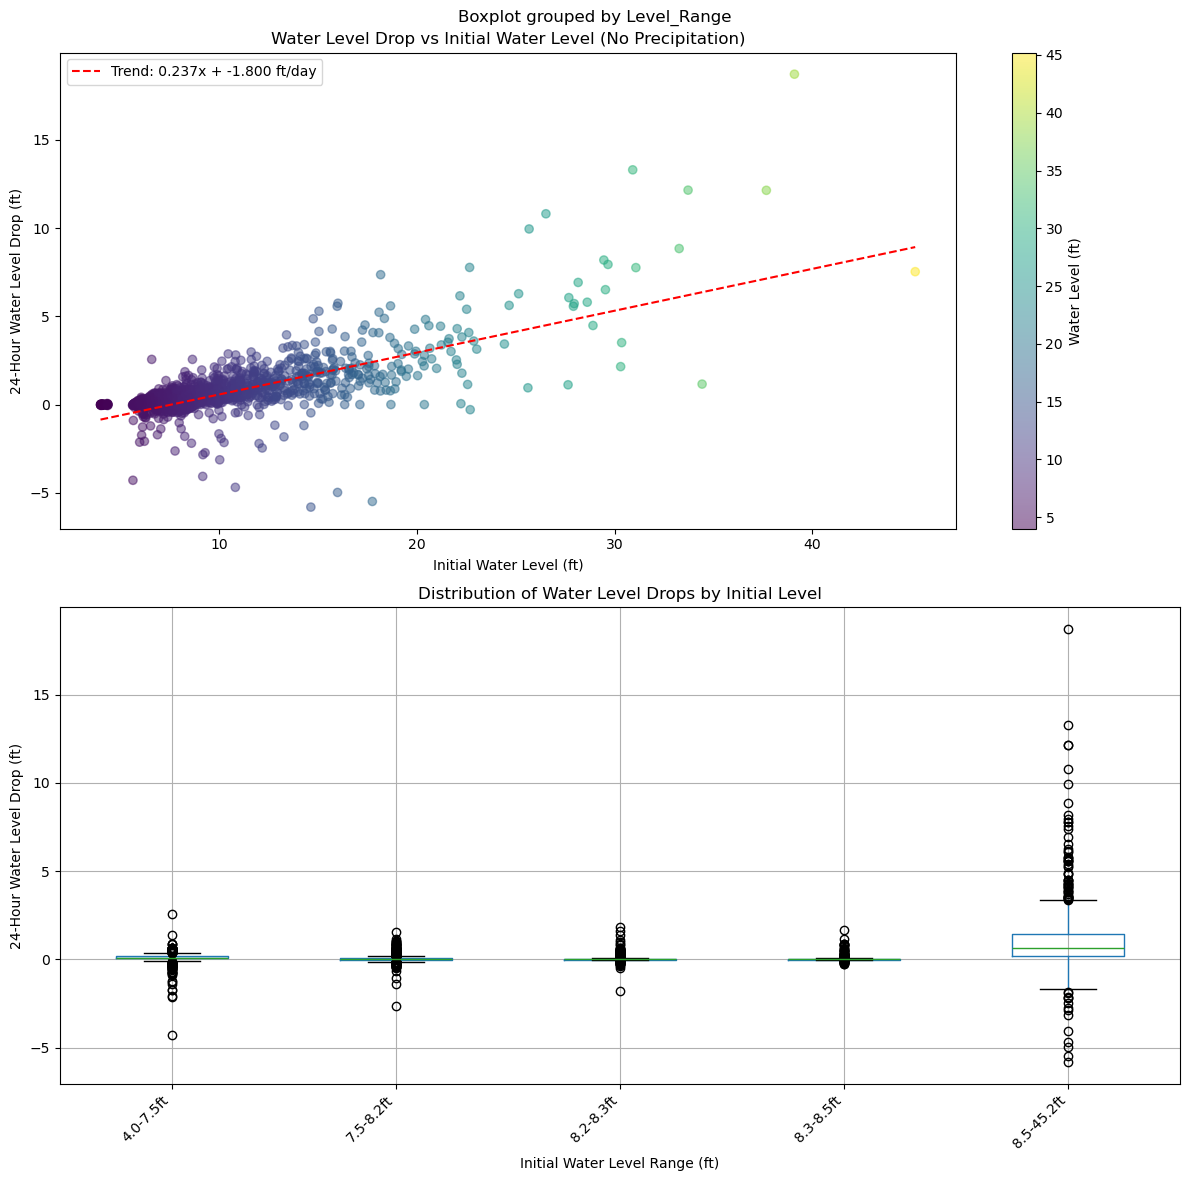

In [28]:
def analyze_water_level_drop(water_df, rain_df):
    """
    Analyze how water level drops over 24 hours when there's no precipitation
    """
    # Merge and prepare data
    combined_df = pd.merge(water_df, rain_df, 
                          left_on='Date', 
                          right_on='Date',
                          how='inner')  # Changed to inner join to ensure matching dates
    
    # Convert Date to datetime if it isn't already
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df = combined_df.sort_values('Date')
    
    # Calculate next day's water level and drop
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    combined_df['Level_Drop'] = combined_df['WaterLevel'] - combined_df['Next_Day_Level']
    
    # Filter for days with no precipitation
    dry_days = combined_df[combined_df['Precipitation'] == 0].copy()
    dry_days = dry_days.dropna(subset=['WaterLevel', 'Level_Drop'])
    
    # Create 5 bins based on water level ranges
    bin_edges = np.percentile(dry_days['WaterLevel'], [0, 20, 40, 60, 80, 100])
    bin_labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}ft' for i in range(len(bin_edges)-1)]
    dry_days['Level_Range'] = pd.cut(dry_days['WaterLevel'], 
                                    bins=bin_edges, 
                                    labels=bin_labels,
                                    include_lowest=True)
    
    # Calculate statistics by water level range
    drops_by_level = dry_days.groupby('Level_Range', observed=True).agg({
        'Level_Drop': ['count', 'mean', 'std', 'min', 'max'],
        'WaterLevel': ['mean']
    }).round(3)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Scatter plot
    scatter = ax1.scatter(dry_days['WaterLevel'], 
                         dry_days['Level_Drop'],
                         alpha=0.5, 
                         c=dry_days['WaterLevel'],  # Color by water level
                         cmap='viridis')
    ax1.set_xlabel('Initial Water Level (ft)')
    ax1.set_ylabel('24-Hour Water Level Drop (ft)')
    ax1.set_title('Water Level Drop vs Initial Water Level (No Precipitation)')
    
    # Add trend line
    z = np.polyfit(dry_days['WaterLevel'], dry_days['Level_Drop'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(dry_days['WaterLevel'].min(), dry_days['WaterLevel'].max(), 100)
    ax1.plot(x_range, p(x_range), "r--", 
             label=f'Trend: {z[0]:.3f}x + {z[1]:.3f} ft/day')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax1, label='Water Level (ft)')
    ax1.legend()
    
    # Box plot
    dry_days.boxplot(column='Level_Drop', 
                     by='Level_Range', 
                     ax=ax2,
                     whis=1.5)  # 1.5 IQR for whiskers
    ax2.set_xlabel('Initial Water Level Range (ft)')
    ax2.set_ylabel('24-Hour Water Level Drop (ft)')
    ax2.set_title('Distribution of Water Level Drops by Initial Level')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    return drops_by_level, dry_days

# Run analysis
level_stats, dry_period_data = analyze_water_level_drop(Water_Level_df, Rain_df)

# Print overall statistics
print("\nOverall Water Level Drop Statistics (No Precipitation):")
print(f"Number of dry days analyzed: {len(dry_period_data)}")
print(f"\nAverage daily drop: {dry_period_data['Level_Drop'].mean():.3f} ft")
print(f"Median daily drop: {dry_period_data['Level_Drop'].median():.3f} ft")
print(f"Standard deviation: {dry_period_data['Level_Drop'].std():.3f} ft")
print(f"Minimum drop: {dry_period_data['Level_Drop'].min():.3f} ft")
print(f"Maximum drop: {dry_period_data['Level_Drop'].max():.3f} ft")

# Print statistics by water level range
print("\nStatistics by Water Level Range (all values in feet):")
print(level_stats)

# Calculate correlation
correlation = dry_period_data['WaterLevel'].corr(dry_period_data['Level_Drop'])
print(f"\nCorrelation between water level and drop rate: {correlation:.3f}")

# Print drop rates as percentages
print("\nDrop Rates as Percentage of Initial Level:")
dry_period_data['Drop_Percentage'] = (dry_period_data['Level_Drop'] / dry_period_data['WaterLevel']) * 100
print(f"Average drop percentage: {dry_period_data['Drop_Percentage'].mean():.2f}%")
print(f"Median drop percentage: {dry_period_data['Drop_Percentage'].median():.2f}%")

As can be seen, the mean drop in water level drop increases as water level increases.  While the chart shows a slight decrease from 4 to 8.5 feet this makes sense.  If the water level is aboive the minimum, it means we have had some recent rain.  The residual rain will limit the drainage numbers.  But at larger levels (above 8.5 ft) we see a substantial jump in the drain off.  This confirms the working theory and feels strongly supported.


## Visualization of actual changes in water level and some water level analysis

In [31]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

def create_interactive_3d_prediction():
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Extract data points
    x = combined_df['WaterLevel'].values
    y = combined_df['Precipitation'].values
    z = combined_df['Next_Day_Level'].values
    
    # Create a regular grid to interpolate the data
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate for smooth surface
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=xi,
        y=yi,
        z=zi,
        opacity=0.7,
        colorscale='Viridis',
        name='Predicted Level',
        showscale=True,
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        )
    ))
    
    # Add scatter points
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=z,
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'Date: {d}<br>Current Level: {cl:.2f} ft<br>Rain: {p:.2f} in<br>Next Day: {nl:.2f} ft' 
              for d, cl, p, nl in zip(combined_df['Date'], 
                                    combined_df['WaterLevel'],
                                    combined_df['Precipitation'],
                                    combined_df['Next_Day_Level'])],
        hoverinfo='text',
        name='Actual Data'
    ))
    
    # Update layout
    fig.update_layout(
        title='Interactive 24-Hour Water Level Actuals',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title='Precipitation (in)',
            zaxis_title='Next Day Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Calculate statistics for annotation
    rmse = np.sqrt(np.mean((combined_df['Next_Day_Level'] - combined_df['WaterLevel'])**2))
    max_rise = np.max(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    max_drop = np.min(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    
    # Add statistics annotation
    stats_text = (f'RMSE: {rmse:.3f} ft<br>'
                 f'Max Rise: {max_rise:.3f} ft<br>'
                 f'Max Drop: {max_drop:.3f} ft')
    
    fig.add_annotation(
        text=stats_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig, combined_df

# Create the interactive plot
fig, prediction_data = create_interactive_3d_prediction()

# Show the plot
fig.show()

def analyze_water_predictions(prediction_data):
    """Analyze water level changes based on precipitation and current levels"""
    
    # Calculate level changes
    prediction_data['Level_Change'] = prediction_data['Next_Day_Level'] - prediction_data['WaterLevel']
    
    # Create precipitation categories
    precipitation_bins = [-0.01, 0, 0.1, 0.5, 1.0, np.inf]
    precipitation_labels = ['No Rain', 'Light', 'Moderate', 'Heavy', 'Very Heavy']
    prediction_data['Rain_Category'] = pd.cut(prediction_data['Precipitation'], 
                                            bins=precipitation_bins,
                                            labels=precipitation_labels)
    
    # Create water level categories
    level_bins = [3.97, 6.62, 7.97, 8.17, 8.69, 45.28]
    level_labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    prediction_data['Level_Category'] = pd.cut(prediction_data['WaterLevel'],
                                             bins=level_bins,
                                             labels=level_labels)
    
    # Print correlations
    print("\nRelationship Analysis:")
    correlation_matrix = prediction_data[['WaterLevel', 'Precipitation', 'Next_Day_Level']].corr()
    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))
    
    # Analyze by precipitation category
    rain_effects = (prediction_data.groupby('Rain_Category', observed=True)
                   ['Level_Change']
                   .agg(['count', 'mean', 'std'])
                   .round(3))
    print("\nWater Level Change by Precipitation (ft):")
    print(rain_effects)
    
    # Analyze by water level category
    level_effects = (prediction_data.groupby('Level_Category', observed=True)
                    ['Level_Change']
                    .agg(['count', 'mean', 'std'])
                    .round(3))
    print("\nWater Level Change by Current Level (ft):")
    print(level_effects)
    
    # Key insights
    print("\nKey Insights:")
    print("1. Precipitation Effects:")
    print(f"  - No rain causes average drop of {rain_effects.loc['No Rain', 'mean']:.3f} ft")
    print(f"  - Very heavy rain causes average rise of {rain_effects.loc['Very Heavy', 'mean']:.3f} ft")
    print(f"  - Most variable changes occur with {rain_effects['std'].idxmax()} rain (std: {rain_effects['std'].max():.3f} ft)")
    
    print("\n2. Water Level Effects:")
    print(f"  - Highest levels tend to drop ({level_effects.loc['Very High', 'mean']:.3f} ft/day)")
    print(f"  - Lower levels tend to rise ({level_effects.loc['Very Low', 'mean']:.3f} ft/day)")
    print(f"  - Most stable at normal levels (std: {level_effects.loc['Normal', 'std']:.3f} ft)")
    
    # Create interaction table
    interaction = pd.pivot_table(prediction_data,
                               values='Level_Change',
                               index='Level_Category',
                               columns='Rain_Category',
                               aggfunc='mean',
                               observed=True)
    
    print("\n3. Combined Effects (Average Level Change in ft):")
    print(interaction.round(3))
    
    return prediction_data

# Run the analysis
analyzed_data = analyze_water_predictions(prediction_data)


Relationship Analysis:

Correlation Matrix:
                WaterLevel  Precipitation  Next_Day_Level
WaterLevel           1.000          0.436           0.922
Precipitation        0.436          1.000           0.631
Next_Day_Level       0.922          0.631           1.000

Water Level Change by Precipitation (ft):
               count   mean    std
Rain_Category                     
No Rain         4550 -0.252  0.893
Light            284 -0.756  1.759
Moderate         424 -0.388  2.437
Heavy            243  0.504  2.651
Very Heavy       410  2.802  4.086

Water Level Change by Current Level (ft):
                count   mean    std
Level_Category                     
Very Low          684  0.141  1.347
Low               887  0.135  1.458
Normal            585  0.044  0.838
High             2129 -0.003  0.470
Very High        1625 -0.301  3.055

Key Insights:
1. Precipitation Effects:
  - No rain causes average drop of -0.252 ft
  - Very heavy rain causes average rise of 2.802 ft
  

With the graph we can see the high degree of varibility in the source data.  However, there are noticeable patterns that we can see.  These observations are confirmed when we look at some of the analysis.  

## Find optimal number of days for prediction using time series cross validation

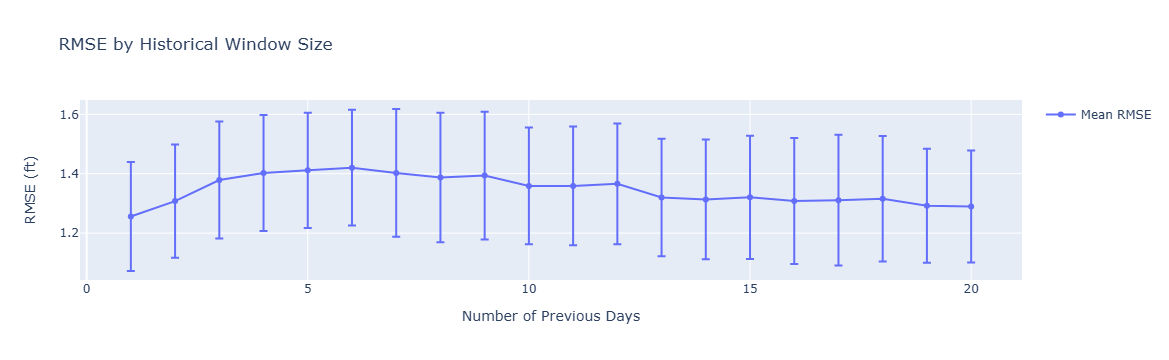

In [34]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def find_optimal_window(Water_Level_df, Rain_df, max_days=20, n_splits=5):
    """Find optimal number of days for prediction using time series cross validation"""
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Sort by date to ensure proper time series analysis
    combined_df = combined_df.sort_values('Date')
    
    # Initialize storage for results
    results = []
    
    # Time series cross validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for window in range(1, max_days + 1):
        rmse_scores = []
        
        # Create historical features
        temp_df = combined_df.copy()
        
        # Add lagged water levels
        for i in range(window):
            temp_df[f'WaterLevel_lag_{i+1}'] = temp_df['WaterLevel'].shift(i+1)
        
        # Add cumulative precipitation
        temp_df['Precip_Sum'] = temp_df['Precipitation'].rolling(window=window).sum()
        
        # Calculate next day's water level
        temp_df['Next_Day_Level'] = temp_df['WaterLevel'].shift(-1)
        
        # Remove rows with NaN
        temp_df = temp_df.dropna()
        
        # Prepare features and target
        X = temp_df[['WaterLevel'] + [f'WaterLevel_lag_{i+1}' for i in range(window)] + ['Precip_Sum']]
        y = temp_df['Next_Day_Level']
        
        # Perform time series cross validation
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Simple linear regression coefficients using numpy
            X_train_arr = np.column_stack([np.ones(len(X_train)), X_train])
            coeffs = np.linalg.pinv(X_train_arr) @ y_train
            
            # Make predictions
            X_test_arr = np.column_stack([np.ones(len(X_test)), X_test])
            y_pred = X_test_arr @ coeffs
            
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse_scores.append(rmse)
        
        results.append({
            'window': window,
            'rmse_mean': np.mean(rmse_scores),
            'rmse_std': np.std(rmse_scores)
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    optimal_window = results_df.loc[results_df['rmse_mean'].idxmin(), 'window']
    
    return int(optimal_window), results_df

def create_interactive_3d_prediction_optimized(Water_Level_df, Rain_df, optimal_window):
    """Create 3D visualization using optimal window for precipitation sum"""
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate precipitation sum for optimal window
    combined_df['Precip_Sum'] = combined_df['Precipitation'].rolling(window=optimal_window).sum()
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Extract data points
    x = combined_df['WaterLevel'].values
    y = combined_df['Precip_Sum'].values
    z = combined_df['Next_Day_Level'].values
    
    # Create a regular grid to interpolate the data
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate for smooth surface
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=xi,
        y=yi,
        z=zi,
        opacity=0.7,
        colorscale='Viridis',
        name='Predicted Level',
        showscale=True,
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        )
    ))
    
    # Add scatter points
    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=z,
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'Date: {d}<br>Current Level: {cl:.2f} ft<br>{optimal_window}-Day Rain Sum: {p:.2f} in<br>Next Day: {nl:.2f} ft' 
              for d, cl, p, nl in zip(combined_df['Date'], 
                                    combined_df['WaterLevel'],
                                    combined_df['Precip_Sum'],
                                    combined_df['Next_Day_Level'])],
        hoverinfo='text',
        name='Actual Data'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Interactive 24-Hour Water Level Prediction (Using {optimal_window}-Day Rain Sum)',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title=f'{optimal_window}-Day Precipitation Sum (in)',
            zaxis_title='Next Day Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    # Calculate statistics for annotation
    rmse = np.sqrt(np.mean((combined_df['Next_Day_Level'] - combined_df['WaterLevel'])**2))
    max_rise = np.max(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    max_drop = np.min(combined_df['Next_Day_Level'] - combined_df['WaterLevel'])
    
    # Add statistics annotation
    stats_text = (f'Optimal Window: {optimal_window} days\n'
                 f'RMSE: {rmse:.3f} ft\n'
                 f'Max Rise: {max_rise:.3f} ft\n'
                 f'Max Drop: {max_drop:.3f} ft')
    
    fig.add_annotation(
        text=stats_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig, combined_df


# First find optimal window
optimal_window, window_results = find_optimal_window(Water_Level_df, Rain_df)

# Create visualization using optimal window
fig, optimized_data = create_interactive_3d_prediction_optimized(Water_Level_df, Rain_df, optimal_window)

# Show the plot
fig.show()

# Plot window analysis results
window_fig = go.Figure()
window_fig.add_trace(go.Scatter(
    x=window_results['window'],
    y=window_results['rmse_mean'],
    mode='lines+markers',
    name='Mean RMSE',
    error_y=dict(
        type='data',
        array=window_results['rmse_std'],
        visible=True
    )
))

window_fig.update_layout(
    title='RMSE by Historical Window Size',
    xaxis_title='Number of Previous Days',
    yaxis_title='RMSE (ft)',
    showlegend=True
)

window_fig.show()

1 day was the optimum from cross-validation and was graphed as a result.  This graph shows the predicted water level based on the previous days' water level and rainfall.

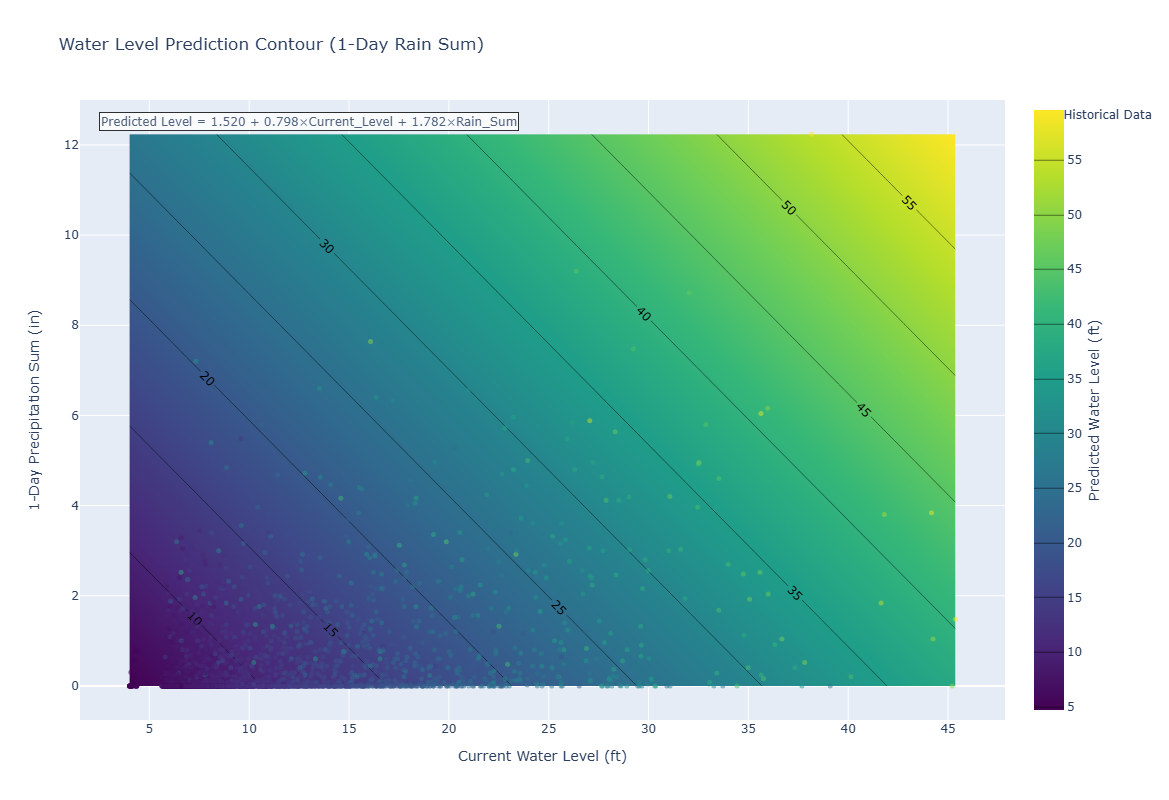

In [36]:
import plotly.graph_objects as go
import numpy as np

def create_prediction_contour(Water_Level_df, Rain_df, optimal_window):
    """Create a contour plot showing predicted water levels based on current level and precipitation"""
    
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate precipitation sum for optimal window
    combined_df['Precip_Sum'] = combined_df['Precipitation'].rolling(window=optimal_window).sum()
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Create a grid of values
    water_levels = np.linspace(combined_df['WaterLevel'].min(), 
                             combined_df['WaterLevel'].max(), 
                             100)
    precip_sums = np.linspace(0,  # Start from 0 precipitation
                             combined_df['Precip_Sum'].max(), 
                             100)
    
    # Create meshgrid
    wl_mesh, precip_mesh = np.meshgrid(water_levels, precip_sums)
    
    # Prepare existing data for model fitting
    X = combined_df[['WaterLevel', 'Precip_Sum']]
    y = combined_df['Next_Day_Level']
    
    # Fit simple linear model
    X_with_const = np.column_stack([np.ones(len(X)), X])
    coefficients = np.linalg.pinv(X_with_const) @ y
    
    # Generate predictions for the mesh
    X_mesh = np.column_stack([
        np.ones(wl_mesh.ravel().shape),
        wl_mesh.ravel(),
        precip_mesh.ravel()
    ])
    predictions = X_mesh @ coefficients
    Z = predictions.reshape(wl_mesh.shape)
    
    # Create the figure
    fig = go.Figure()
    
    # Add contour plot
    fig.add_trace(go.Contour(
        x=water_levels,
        y=precip_sums,
        z=Z,
        colorscale='Viridis',
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        ),
        contours=dict(
            coloring='heatmap',
            showlabels=True
        )
    ))
    
    # Add scatter points of actual data
    fig.add_trace(go.Scatter(
        x=combined_df['WaterLevel'],
        y=combined_df['Precip_Sum'],
        mode='markers',
        marker=dict(
            color=combined_df['Next_Day_Level'],
            colorscale='Viridis',
            size=5,
            opacity=0.5,
            showscale=False
        ),
        name='Historical Data'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Water Level Prediction Contour ({optimal_window}-Day Rain Sum)',
        xaxis_title='Current Water Level (ft)',
        yaxis_title=f'{optimal_window}-Day Precipitation Sum (in)',
        width=1000,
        height=800,
        showlegend=True
    )
    
    # Add model equation annotation
    equation_text = (f'Predicted Level = {coefficients[0]:.3f} + '
                    f'{coefficients[1]:.3f}×Current_Level + '
                    f'{coefficients[2]:.3f}×Rain_Sum')
    
    fig.add_annotation(
        text=equation_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig

# Create and show the contour plot
contour_fig = create_prediction_contour(Water_Level_df, Rain_df, optimal_window)
contour_fig.show()


In [37]:
def create_prediction_surface(Water_Level_df, Rain_df, optimal_window):
    """Create a 3D surface plot showing predicted water levels based on current level and precipitation"""
    
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate precipitation sum for optimal window
    combined_df['Precip_Sum'] = combined_df['Precipitation'].rolling(window=optimal_window).sum()
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Create a grid of values
    water_levels = np.linspace(combined_df['WaterLevel'].min(), 
                             combined_df['WaterLevel'].max(), 
                             100)
    precip_sums = np.linspace(0,  # Start from 0 precipitation
                             combined_df['Precip_Sum'].max(), 
                             100)
    
    # Create meshgrid
    wl_mesh, precip_mesh = np.meshgrid(water_levels, precip_sums)
    
    # Prepare existing data for model fitting
    X = combined_df[['WaterLevel', 'Precip_Sum']]
    y = combined_df['Next_Day_Level']
    
    # Fit simple linear model
    X_with_const = np.column_stack([np.ones(len(X)), X])
    coefficients = np.linalg.pinv(X_with_const) @ y
    
    # Generate predictions for the mesh
    X_mesh = np.column_stack([
        np.ones(wl_mesh.ravel().shape),
        wl_mesh.ravel(),
        precip_mesh.ravel()
    ])
    predictions = X_mesh @ coefficients
    Z = predictions.reshape(wl_mesh.shape)
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=water_levels,
        y=precip_sums,
        z=Z,
        colorscale='Viridis',
        name='Predicted Level',
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        ),
        opacity=0.8
    ))
    
    # Add scatter points of actual data
    fig.add_trace(go.Scatter3d(
        x=combined_df['WaterLevel'],
        y=combined_df['Precip_Sum'],
        z=combined_df['Next_Day_Level'],
        mode='markers',
        marker=dict(
            color=combined_df['Next_Day_Level'],
            colorscale='Viridis',
            size=3,
            opacity=0.6,
            showscale=False
        ),
        name='Historical Data'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Water Level Prediction Surface ({optimal_window}-Day Rain Sum)',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title=f'{optimal_window}-Day Precipitation Sum (in)',
            zaxis_title='Predicted Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True
    )
    
    # Add model equation annotation
    equation_text = (f'Predicted Level = {coefficients[0]:.3f} + '
                    f'{coefficients[1]:.3f}×Current_Level + '
                    f'{coefficients[2]:.3f}×Rain_Sum')
    
    fig.add_annotation(
        text=equation_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig, coefficients

# Create and show the surface plot
surface_fig, model_coefficients = create_prediction_surface(Water_Level_df, Rain_df, optimal_window)
surface_fig.show()

# Print model interpretation
print("\nModel Interpretation:")
print(f"Baseline water level: {model_coefficients[0]:.3f} ft")
print(f"For each 1 ft increase in current water level: {model_coefficients[1]:.3f} ft change")
print(f"For each 1 inch increase in {optimal_window}-day rain sum: {model_coefficients[2]:.3f} ft change")


Model Interpretation:
Baseline water level: 1.520 ft
For each 1 ft increase in current water level: 0.798 ft change
For each 1 inch increase in 1-day rain sum: 1.782 ft change


This graph looks like our linear ARIMA model but more accurate.  As with ARIMA above I next add polynomial features.


Model Comparison Results:
   degree  rmse_mean  rmse_std  r2_mean  r2_std
0       1     1.2728    0.1650   0.9093  0.0259
1       2     1.2610    0.1529   0.9108  0.0254
2       3     1.2539    0.1574   0.9111  0.0274
3       4     1.4614    0.4139   0.8835  0.0403

Best polynomial degree: 3


C:\Users\micro\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



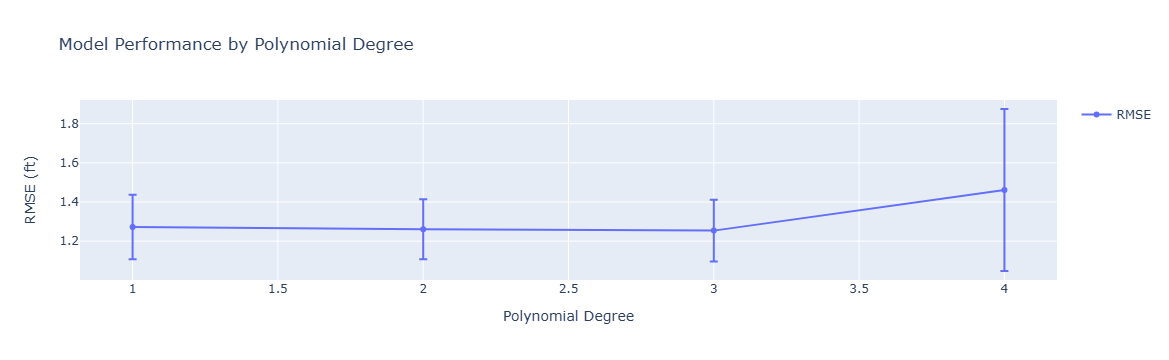

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

def create_nonlinear_prediction_surface(Water_Level_df, Rain_df, optimal_window, degree=2):
    """Create a 3D surface plot showing predicted water levels using non-linear model"""
    
    # Merge the dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    
    # Calculate precipitation sum for optimal window
    combined_df['Precip_Sum'] = combined_df['Precipitation'].rolling(window=optimal_window).sum()
    
    # Calculate next day's water level
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    
    # Remove any rows with NaN
    combined_df = combined_df.dropna()
    
    # Create a grid of values
    water_levels = np.linspace(combined_df['WaterLevel'].min(), 
                             combined_df['WaterLevel'].max(), 
                             100)
    precip_sums = np.linspace(0,  # Start from 0 precipitation
                             combined_df['Precip_Sum'].max(), 
                             100)
    
    # Create meshgrid
    wl_mesh, precip_mesh = np.meshgrid(water_levels, precip_sums)
    
    # Prepare existing data for model fitting
    X = combined_df[['WaterLevel', 'Precip_Sum']]
    y = combined_df['Next_Day_Level']
    
    # Create non-linear model pipeline
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=degree, include_bias=False),
        Ridge(alpha=0.1)  # Using Ridge regression to prevent overfitting
    )
    
    # Fit the model
    model.fit(X, y)
    
    # Prepare mesh data for prediction
    X_mesh = np.column_stack([wl_mesh.ravel(), precip_mesh.ravel()])
    predictions = model.predict(X_mesh)
    Z = predictions.reshape(wl_mesh.shape)
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=water_levels,
        y=precip_sums,
        z=Z,
        colorscale='Viridis',
        name='Predicted Level',
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        ),
        opacity=0.8
    ))
    
    # Add scatter points of actual data
    fig.add_trace(go.Scatter3d(
        x=combined_df['WaterLevel'],
        y=combined_df['Precip_Sum'],
        z=combined_df['Next_Day_Level'],
        mode='markers',
        marker=dict(
            color=combined_df['Next_Day_Level'],
            colorscale='Viridis',
            size=3,
            opacity=0.6,
            showscale=False
        ),
        name='Historical Data'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Non-linear Water Level Prediction (Degree {degree}, {optimal_window}-Day Rain Sum)',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title=f'{optimal_window}-Day Precipitation Sum (in)',
            zaxis_title='Predicted Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True
    )
    
    # Calculate model performance metrics
    train_predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, train_predictions))
    r2 = model.score(X, y)
    
    # Add performance metrics annotation
    metrics_text = (f'Model Performance:\n'
                   f'RMSE: {rmse:.3f} ft\n'
                   f'R²: {r2:.3f}\n'
                   f'Polynomial Degree: {degree}')
    
    fig.add_annotation(
        text=metrics_text,
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        opacity=0.8,
        bordercolor="black",
        borderwidth=1
    )
    
    return fig, model

def compare_models_performance(Water_Level_df, Rain_df, optimal_window, max_degree=4):
    """Compare performance of different polynomial degrees"""
    results = []
    
    # Prepare data
    combined_df = pd.merge(Water_Level_df, Rain_df, 
                          on='Date', 
                          how='inner')
    combined_df['Precip_Sum'] = combined_df['Precipitation'].rolling(window=optimal_window).sum()
    combined_df['Next_Day_Level'] = combined_df['WaterLevel'].shift(-1)
    combined_df = combined_df.dropna()
    
    X = combined_df[['WaterLevel', 'Precip_Sum']]
    y = combined_df['Next_Day_Level']
    
    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)
    
    for degree in range(1, max_degree + 1):
        cv_scores = {'rmse': [], 'r2': []}
        
        model = make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=degree, include_bias=False),
            Ridge(alpha=0.1)
        )
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            cv_scores['r2'].append(model.score(X_test, y_test))
        
        results.append({
            'degree': degree,
            'rmse_mean': np.mean(cv_scores['rmse']),
            'rmse_std': np.std(cv_scores['rmse']),
            'r2_mean': np.mean(cv_scores['r2']),
            'r2_std': np.std(cv_scores['r2'])
        })
    
    return pd.DataFrame(results)

# Compare different polynomial degrees
comparison_results = compare_models_performance(Water_Level_df, Rain_df, optimal_window)
print("\nModel Comparison Results:")
print(comparison_results.round(4))

# Create plot for best degree based on results
best_degree = comparison_results.loc[comparison_results['rmse_mean'].idxmin(), 'degree']
print(f"\nBest polynomial degree: {best_degree}")

# Create and show the surface plot with best degree
surface_fig, best_model = create_nonlinear_prediction_surface(
    Water_Level_df, Rain_df, optimal_window, degree=int(best_degree)
)
surface_fig.show()

# Create comparison visualization
comparison_fig = go.Figure()

comparison_fig.add_trace(go.Scatter(
    x=comparison_results['degree'],
    y=comparison_results['rmse_mean'],
    mode='lines+markers',
    name='RMSE',
    error_y=dict(
        type='data',
        array=comparison_results['rmse_std'],
        visible=True
    )
))

comparison_fig.update_layout(
    title='Model Performance by Polynomial Degree',
    xaxis_title='Polynomial Degree',
    yaxis_title='RMSE (ft)',
    showlegend=True
)

comparison_fig.show()

This is the best model so far.  At low water levels we see an exponential increase in water level as rain increases.  This makes sense as more water will make it to the river and not be absorbed into the earth or other run off options.  We also see a continued reduction in impact per delta in rainfall as water level increases.  This was my theory as the banks of the river widen as the river gets higher.  While only about 100 feet across at 5 feet, the river may be 1/4 mile wide at 40 feet.  The volume of water should increase dramatically as the river height increases meaning more rainfall has less impact.  This is easily seen in this graph.  One anomoly in the graph is that it says that at the highest levels (40+ feet) there is a reduction in water level from about 5-10 inches of rain.  This is counter-intuitive but can easily be attributed to the sparse data for that region of the graph with only about 5 data points in decades of data above 40 feet and none of those in that 5-10 inches of rain region.  The prediction appears to have been unduly influenced by the 3 sparse data points in the 25-30 foot region.  All in all, this graph appears to present the best visualization of the relationships that I was looking for.  It also can be used to predict future water levels so I know if I need to move things out of my garage for a flood.

Data range - Water: [4.00, 23.24]
Data range - Precip: [0.00, 7.64]
Epoch [10/50], Train Loss: 0.016395, Val Loss: 0.013955
Epoch [20/50], Train Loss: 0.014914, Val Loss: 0.012751
Epoch [30/50], Train Loss: 0.014178, Val Loss: 0.014705
Epoch [40/50], Train Loss: 0.014015, Val Loss: 0.012585
Epoch [50/50], Train Loss: 0.013672, Val Loss: 0.012736


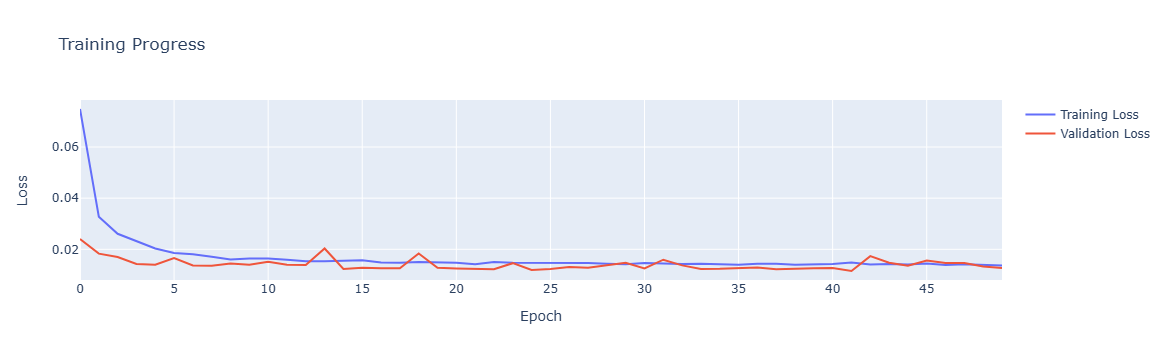

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import plotly.graph_objects as go

class WaterLevelDataset(Dataset):
    def __init__(self, water_levels, precipitation, sequence_length):
        self.sequence_length = sequence_length
        
        # Normalize the data with a wider range to prevent numerical issues
        self.scaler_water = MinMaxScaler(feature_range=(-0.9, 0.9))
        self.scaler_precip = MinMaxScaler(feature_range=(-0.9, 0.9))
        
        water_levels_normalized = self.scaler_water.fit_transform(water_levels.reshape(-1, 1))
        precip_normalized = self.scaler_precip.fit_transform(precipitation.reshape(-1, 1))
        
        # Create sequences
        X_water = []
        X_precip = []
        y = []
        
        for i in range(len(water_levels) - sequence_length):
            X_water.append(water_levels_normalized[i:i+sequence_length])
            X_precip.append(precip_normalized[i:i+sequence_length])
            y.append(water_levels_normalized[i+sequence_length])
            
        self.X_water = torch.FloatTensor(np.array(X_water))
        self.X_precip = torch.FloatTensor(np.array(X_precip))
        self.y = torch.FloatTensor(np.array(y))
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.X_water[idx], self.X_precip[idx]), self.y[idx]
    
    def inverse_transform_water(self, data):
        return self.scaler_water.inverse_transform(data.reshape(-1, 1))
    
    def inverse_transform_precip(self, data):
        return self.scaler_precip.inverse_transform(data.reshape(-1, 1))

class LSTMPredictor(nn.Module):
    def __init__(self, sequence_length, hidden_size=32, num_layers=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Simplified architecture with gradient clipping built in
        self.lstm_water = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.lstm_precip = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Smaller network with batch normalization
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        x_water, x_precip = x
        
        # Process water levels
        lstm_out_water, _ = self.lstm_water(x_water)
        water_features = lstm_out_water[:, -1, :]
        
        # Process precipitation
        lstm_out_precip, _ = self.lstm_precip(x_precip)
        precip_features = lstm_out_precip[:, -1, :]
        
        # Combine features with batch normalization
        combined = torch.cat((water_features, precip_features), dim=1)
        combined = self.bn(combined)
        
        # Make prediction
        out = self.fc(combined)
        return out

def train_lstm_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Use MSE loss with reduction='none' to check for NaN values
    criterion = nn.MSELoss(reduction='none')
    
    # Use a smaller learning rate and gradient clipping
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        valid_batches = 0
        
        for batch_X, batch_y in train_loader:
            batch_X = (batch_X[0].to(device), batch_X[1].to(device))
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            
            # Check for NaN values
            loss = criterion(outputs, batch_y)
            if torch.isnan(loss).any():
                print(f"NaN loss detected in batch")
                continue
                
            loss = loss.mean()
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            valid_batches += 1
        
        if valid_batches > 0:
            train_loss = train_loss / valid_batches
        
        # Validation
        model.eval()
        val_loss = 0
        valid_batches = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = (batch_X[0].to(device), batch_X[1].to(device))
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                if not torch.isnan(loss).any():
                    val_loss += loss.mean().item()
                    valid_batches += 1
        
        if valid_batches > 0:
            val_loss = val_loss / valid_batches
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

# Modified data preparation to include error checking
def prepare_data(Water_Level_df, Rain_df, sequence_length=3):  # Reduced sequence length
    # Merge dataframes
    combined_df = pd.merge(Water_Level_df, Rain_df, on='Date', how='inner')
    
    # Sort by date and handle missing values
    combined_df = combined_df.sort_values('Date').dropna()
    
    # Remove outliers
    water_mean = combined_df['WaterLevel'].mean()
    water_std = combined_df['WaterLevel'].std()
    combined_df = combined_df[
        (combined_df['WaterLevel'] > water_mean - 3 * water_std) &
        (combined_df['WaterLevel'] < water_mean + 3 * water_std)
    ]
    
    # Extract arrays
    water_levels = combined_df['WaterLevel'].values
    precipitation = combined_df['Precipitation'].values
    
    # Verify data
    print(f"Data range - Water: [{water_levels.min():.2f}, {water_levels.max():.2f}]")
    print(f"Data range - Precip: [{precipitation.min():.2f}, {precipitation.max():.2f}]")
    
    # Create dataset
    dataset = WaterLevelDataset(water_levels, precipitation, sequence_length)
    
    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders with smaller batch size
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    return dataset, train_loader, val_loader

# Initialize and train
sequence_length = 10  # Reduced sequence length
dataset, train_loader, val_loader = prepare_data(Water_Level_df, Rain_df, sequence_length)

# Create and train model with simplified architecture
model = LSTMPredictor(sequence_length, hidden_size=32, num_layers=1)
train_losses, val_losses = train_lstm_model(model, train_loader, val_loader)

# Plot training progress
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(y=train_losses, name='Training Loss'))
loss_fig.add_trace(go.Scatter(y=val_losses, name='Validation Loss'))
loss_fig.update_layout(title='Training Progress', xaxis_title='Epoch', yaxis_title='Loss')
loss_fig.show()

In [42]:
def create_prediction_surface_lstm(model, dataset, water_range, precip_range, sequence_length):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Create meshgrid
    water_levels = np.linspace(water_range[0], water_range[1], 50)
    precip_sums = np.linspace(precip_range[0], precip_range[1], 50)
    wl_mesh, precip_mesh = np.meshgrid(water_levels, precip_sums)
    
    # Initialize predictions array
    Z = np.zeros_like(wl_mesh)
    
    # Generate predictions
    with torch.no_grad():
        for i in range(wl_mesh.shape[0]):
            for j in range(wl_mesh.shape[1]):
                # Create sequence with constant values
                water_seq = np.full(sequence_length, wl_mesh[i,j])
                precip_seq = np.full(sequence_length, precip_mesh[i,j]/sequence_length)  # Distribute precip over sequence
                
                # Normalize sequences
                water_seq = dataset.scaler_water.transform(water_seq.reshape(-1, 1))
                precip_seq = dataset.scaler_precip.transform(precip_seq.reshape(-1, 1))
                
                # Convert to tensors
                water_seq = torch.FloatTensor(water_seq).unsqueeze(0).to(device)
                precip_seq = torch.FloatTensor(precip_seq).unsqueeze(0).to(device)
                
                # Make prediction
                pred = model((water_seq, precip_seq))
                pred = dataset.inverse_transform_water(pred.cpu().numpy())[0,0]
                Z[i,j] = pred
    
    # Create the figure
    fig = go.Figure()
    
    # Add surface plot
    fig.add_trace(go.Surface(
        x=water_levels,
        y=precip_sums,
        z=Z,
        colorscale='Viridis',
        name='Predicted Level',
        colorbar=dict(
            title='Predicted Water Level (ft)',
            titleside='right'
        ),
        opacity=0.8
    ))
    
    # Update layout
    fig.update_layout(
        title=f'LSTM Water Level Prediction Surface',
        scene=dict(
            xaxis_title='Current Water Level (ft)',
            yaxis_title=f'Total {sequence_length}-Day Precipitation (in)',
            zaxis_title='Predicted Next-Day Water Level (ft)',
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True
    )
    
    return fig

# Create prediction surface
water_range = (4.0, 50)  # From your data range
precip_range = (0, 20)  # Adjusted for sequence sum
surface_fig = create_prediction_surface_lstm(model, dataset, water_range, precip_range, sequence_length=3)
surface_fig.show()

This final model is a graph based on a LSTM model.  While it does show some of the characteristics that we see in the linear regression models, the variations are very subtle and individual data points look questionable if not outright doubtful.  It feels like it sees some of the pattern but doesn't quite make the right decisions and leans too strongly towards a norm.  My conclusion is that the time series models were not as accurate as the linear regression models.

## Final thoughts

I was surpised that the time series models did not seem to perform as well as the linear regression.  While the behavior is obviously time related, the strong correlation with only the most recent data points and the high variance in the data and lack of seasonality make time-series a bad choice.  I would use the linear polynomial graph above as my predictor and I can refine and improve that model moving forward.